In [1]:
# this is run after TACC accomplishes and writes data into output/analysis/hemispherical_sessile_droplet_study/
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from scipy.optimize import root
from scipy.stats import linregress
from scipy.integrate import dblquad
from joblib import Parallel, delayed

from tqdm import tqdm
# from tabulate import tabulate
# plt.rcParams['text.usetex'] = True
markers = {'0.5':'o', '1':'^', '2':'s', '3':'D'}
colors  = {'0.5':'tab:blue', '1':'tab:orange', '2':'tab:green', '3':'tab:red'}

## Gather Data from output/analysis/catenoid

In [2]:
def read_data(input_directory="../../output/analysis/catenoid/convergence/"):
    # determine what simulations were done
    all_sims = os.listdir(input_directory)

    grid_density_parameters_set = set()
    mesh_density_parameters_set = set()
    for sim_name in all_sims:
        if not os.path.isdir(input_directory + sim_name):
            continue 
        
        grid_density_string, mesh_density_string = sim_name.split("_")
        grid_density, mesh_density = int(grid_density_string[1:]), (mesh_density_string[2:])
        grid_density_parameters_set.add(grid_density)
        mesh_density_parameters_set.add(mesh_density)

    grid_density_parameters = sorted(list(grid_density_parameters_set))
    mesh_density_parameters = sorted(list(mesh_density_parameters_set))

    # read in the data for the parameter study
    # radii_data = [[([], [], []) for x in range(len(grid_density_parameters))] for y in range(len(mesh_density_parameters))]
    point_data = [[([], [], []) for x in range(len(grid_density_parameters))] for y in range(len(mesh_density_parameters))]
    for i, mesh_density in enumerate(mesh_density_parameters):
        for j, grid_h in enumerate(grid_density_parameters):
            sim_directory = input_directory + "h" + str(grid_h) + "_mp" + str(mesh_density) + "/"
            print(f"Processing {sim_directory}")
            if not os.path.isdir(sim_directory):
                continue

            result_directory = sim_directory + "results/"
            if not os.path.isdir(result_directory) or not os.path.exists(result_directory + "COMPLETE"):
                continue

            # now read the data
            with open(result_directory + "vertex_list.tsv") as f:
                p1_points, p2_points, p3_points = point_data[i][j]
                # z_values, r_values, a_values = radii_data[i][j]
                f.readline()
                for line in f:
                    p1x, p1y, p1z, p2x, p2y, p2z, p3x, p3y, p3z = line.split("\t")
                    p1_points.append((float(p1x), float(p1y), float(p1z)))
                    p2_points.append((float(p2x), float(p2y), float(p2z)))
                    p3_points.append((float(p3x), float(p3y), float(p3z)))
                    # z, r, a = line.split("\t")
                    # z_values.append(float(z)); r_values.append(float(r)); a_values.append(float(a))
                print(len(p1_points))


    return (point_data, (grid_density_parameters, mesh_density_parameters))

point_data, parameters = read_data()

Processing ../../output/analysis/catenoid/convergence/h4_mp0.5/
48
Processing ../../output/analysis/catenoid/convergence/h8_mp0.5/
192
Processing ../../output/analysis/catenoid/convergence/h16_mp0.5/
800
Processing ../../output/analysis/catenoid/convergence/h32_mp0.5/
3200
Processing ../../output/analysis/catenoid/convergence/h64_mp0.5/
12800
Processing ../../output/analysis/catenoid/convergence/h4_mp1/
192
Processing ../../output/analysis/catenoid/convergence/h8_mp1/
800
Processing ../../output/analysis/catenoid/convergence/h16_mp1/
3200
Processing ../../output/analysis/catenoid/convergence/h32_mp1/
12800
Processing ../../output/analysis/catenoid/convergence/h64_mp1/
51456
Processing ../../output/analysis/catenoid/convergence/h4_mp2/
800
Processing ../../output/analysis/catenoid/convergence/h8_mp2/
3200
Processing ../../output/analysis/catenoid/convergence/h16_mp2/
12800
Processing ../../output/analysis/catenoid/convergence/h32_mp2/
51456
Processing ../../output/analysis/catenoid/conv

In [3]:
print(parameters)

([4, 8, 16, 32, 64], ['0.5', '1', '2', '3'])


## Regression Error Analysis on Radii

In [4]:
def catenoid(x, A, B=1):
    return A * np.cosh((x - B) / A)

In [5]:
sol = root(lambda A: catenoid(2.0, A, 1.0) - 2.0, x0=2.0)
A = sol.x[0]
B = 1.0
print(sol.x[0])

1.6966758761899579


In [6]:
def x(xi, eta, x1, x2, x3):
    """
    Given barycentric parameters (xi, eta) and the vertices x1, x2, x3,
    returns the point on the triangle:
        x(xi, eta) = (1 - xi - eta)*x1 + xi*x2 + eta*x3.
    """
    # Convert vertices to numpy arrays for vectorized operations.
    return (1 - xi - eta)*x1 + xi*x2 + eta*x3

In [7]:
def integrate_triangle_error(x1, x2, x3):
    """
    Given the three vertices of a triangle
    that returns the expected radius at height z, this function integrates the error
    (r_actual - r_expected)^2 over the triangle.
    
    The integrand is:
        f(ξ,η) = [ sqrt(x(ξ,η)_x^2 + x(ξ,η)_y^2) - catenoid( z(ξ,η) ) ]^2
                 * |(x2 - x1) x (x3 - x1)|.
                 
    The integration is done over ξ ∈ [0,1] and η ∈ [0, 1-ξ] using dblquad.
    """
    # Compute the constant factor: the norm of the cross product gives the Jacobian of the mapping.
    area_vector = np.linalg.cross(x2-x1, x3-x1)
    area_factor = np.linalg.norm(area_vector)
    
    # Note: In dblquad the integrand must have signature f(eta, xi) (inner variable first).
    def integrand(eta, xi):
        # Map (xi, eta) to a point on the triangle.
        point = x(xi, eta, x1, x2, x3)
        x_val, y_val, z_val = point
        # Compute the actual radius from the x and y coordinates.
        r_actual = np.sqrt(x_val**2 + y_val**2)
        # The error is the difference between the actual radius and the expected radius from catenoid(z).
        err = r_actual - catenoid(z_val, A)
        return err**2 * area_factor

    # Integration limits:
    #   xi goes from 0 to 1,
    #   For each xi, eta goes from 0 to 1 - xi.
    result, abserr = dblquad(integrand, 0, 1, lambda xi: 0, lambda xi: 1 - xi, epsabs=1e-18, epsrel=1e-18)
    return result

def integrate_exactnorm(x1, x2, x3):
    """
    """
    # Compute the constant factor: the norm of the cross product gives the Jacobian of the mapping.
    area_vector = np.linalg.cross(x2-x1, x3-x1)
    area_factor = np.linalg.norm(area_vector)
    
    # Note: In dblquad the integrand must have signature f(eta, xi) (inner variable first).
    def integrand(eta, xi):
        # Map (xi, eta) to a point on the triangle.
        point = x(xi, eta, x1, x2, x3)
        x_val, y_val, z_val = point
        # The error is the difference between the actual radius and the expected radius from catenoid(z).
        err = catenoid(z_val, A)
        return err**2 * area_factor

    # Integration limits:
    #   xi goes from 0 to 1,
    #   For each xi, eta goes from 0 to 1 - xi.
    result, abserr = dblquad(integrand, 0, 1, lambda xi: 0, lambda xi: 1 - xi, epsabs=1e-18, epsrel=1e-18)
    return result

In [8]:
def calculate_error(vertex_data, parameters):
    grid_density_parameters, mp_per_cell_parameters = parameters

    all_error = [[0.0 for x in range(len(grid_density_parameters))] for y in range(len(mp_per_cell_parameters))]
    all_error_norm = [[0.0 for x in range(len(grid_density_parameters))] for y in range(len(mp_per_cell_parameters))]
    for i in range(len(mp_per_cell_parameters)):
        for j in range(len(grid_density_parameters)):
            print(f"Calculating error for ppc={mp_per_cell_parameters[i]} and h={grid_density_parameters[j]}")
            p1_data, p2_data, p3_data = vertex_data[i][j]

            errors = Parallel(n_jobs=8)(
                delayed(integrate_triangle_error)(np.array(p1), np.array(p2), np.array(p3))
                for p1,p2,p3 in zip(p1_data, p2_data, p3_data)
            )
            norms = Parallel(n_jobs=8)(
                delayed(integrate_exactnorm)(np.array(p1), np.array(p2), np.array(p3))
                for p1,p2,p3 in zip(p1_data, p2_data, p3_data)
            )

            all_error[i][j]      = np.sqrt(sum(errors))
            all_error_norm[i][j] = np.sqrt(sum(norms))
        
    return all_error, all_error_norm

all_error, all_error_norm = calculate_error(point_data, parameters)

Calculating error for ppc=0.5 and h=4


/home/noh/dev/research/SimpleMPM/.venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/noh/dev/research/SimpleMPM/.venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/noh/dev/research/SimpleMPM/.venv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, f

Calculating error for ppc=0.5 and h=8
Calculating error for ppc=0.5 and h=16
Calculating error for ppc=0.5 and h=32
Calculating error for ppc=0.5 and h=64
Calculating error for ppc=1 and h=4
Calculating error for ppc=1 and h=8
Calculating error for ppc=1 and h=16
Calculating error for ppc=1 and h=32
Calculating error for ppc=1 and h=64
Calculating error for ppc=2 and h=4
Calculating error for ppc=2 and h=8
Calculating error for ppc=2 and h=16
Calculating error for ppc=2 and h=32
Calculating error for ppc=2 and h=64
Calculating error for ppc=3 and h=4
Calculating error for ppc=3 and h=8
Calculating error for ppc=3 and h=16
Calculating error for ppc=3 and h=32
Calculating error for ppc=3 and h=64


In [9]:
print(all_error)
print(all_error_norm)

[[np.float64(0.018324010236462088), np.float64(0.004590657535863409), np.float64(0.0011328101862460357), np.float64(0.0002834219360992081), np.float64(7.149616515616905e-05)], [np.float64(0.004586801405679524), np.float64(0.0011316899748554617), np.float64(0.0002832930651177308), np.float64(7.133285680092941e-05), np.float64(2.0450564864732045e-05)], [np.float64(0.005188993162047925), np.float64(0.0010855857348907624), np.float64(0.0002241079440941984), np.float64(3.600195016708076e-05), np.float64(9.288358443746694e-06)], [np.float64(0.005950933308653598), np.float64(0.0013127686979425889), np.float64(0.0002721144765067053), np.float64(4.683476568528485e-05), np.float64(7.262302650470703e-06)]]
[[np.float64(4.421406571098728), np.float64(4.424834738095126), np.float64(4.425772663867132), np.float64(4.4259711448205366), np.float64(4.426020767283917)], [np.float64(4.424838854951913), np.float64(4.425773357687992), np.float64(4.425971192098635), np.float64(4.426020821936861), np.float64(

-1.992988672253992
-1.8960514358538265
-2.296313619809812
-2.613820051760782


/tmp/ipykernel_149767/191253376.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


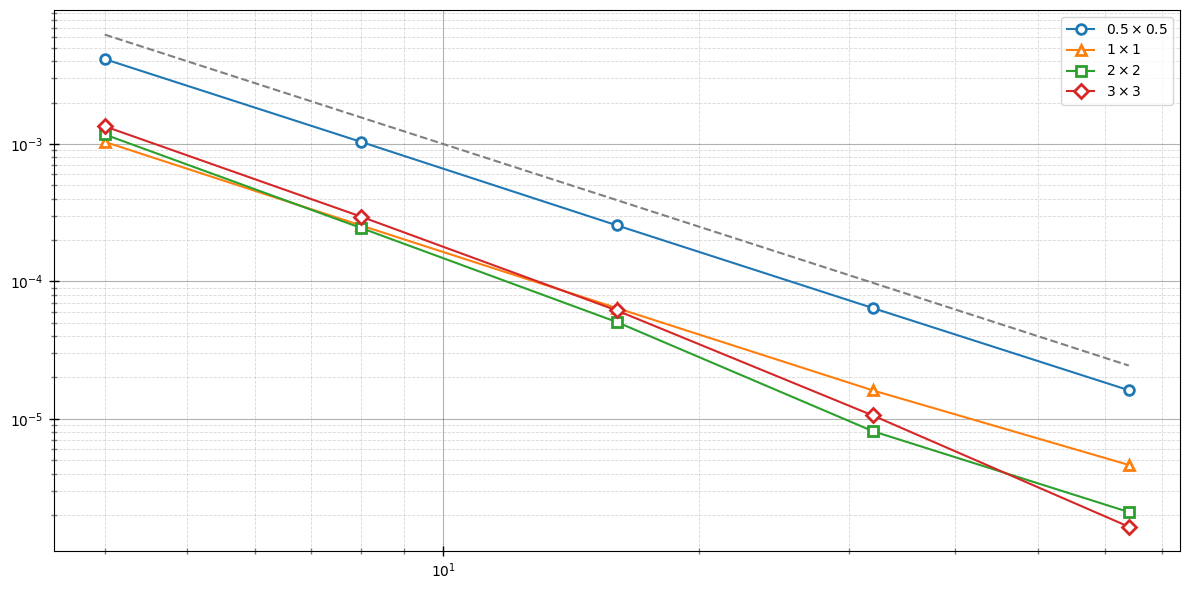

In [15]:
def printL2RadiusRelError(parameters):
    grid_density_parameters, mp_per_cell_parameters = parameters

    log_h = [np.log10(h) for h in grid_density_parameters]

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, mp_per_cell in enumerate(mp_per_cell_parameters):
        error_list = all_error[i]
        error_norms_list = all_error_norm[i]

        normed_error = [(error_list[j] / error_norms_list[j]) for j in range(len(error_list))]
        logged_error = [np.log10(norm_error) for norm_error in normed_error]
        res = linregress(log_h[2:], logged_error[2:])
        print(res.slope)
        ax.loglog(grid_density_parameters, normed_error, 
                    marker=markers[mp_per_cell],
                    markersize=7,
                    linestyle='-',
                    color=colors[mp_per_cell],
                    alpha=1.0,
                    markerfacecolor='white',
                    markeredgewidth=2.0,
                    label=f"${mp_per_cell}\\times{mp_per_cell}$")
        
    xfine=np.linspace(4, 64, 1000)
    ax.loglog(xfine, 0.1*np.pow(xfine, -2), color="grey", linestyle="--")
    
    ax.legend()
    ax.grid(True, which='major', linestyle='-', linewidth=0.8, color='black', alpha=0.3)
    ax.grid(True, which='minor', linestyle='--', linewidth=0.6, color='gray', alpha=0.3)
    # ax.set_xlabel("Grid Spacing $h^{-1}$")
    # ax.set_ylabel("L2 Average Error of Radii $\|e\|_2$")
    ax.tick_params(axis='both', which='major', direction='inout', length=7.5, width=1, colors='black')
    ax.tick_params(axis='both', which='minor', direction='inout', length=5, width=1, colors='gray')
    
    fig.tight_layout()
    fig.savefig("../../ex1_convergence.svg")
    fig.show()

printL2RadiusRelError(parameters)